## EDA Plan:
1. Clean districts_info.csv such that data can be interpreted easily
2. Merge engagement data for all districts
3. EDA on district and engagement data to see general trends, possibilities of correlations
4. Merging dataset into pandas, remmoving redundant rows/columns
5. Switching to a sqlite database if needed

In [1]:
# Importing the required libraries
import pandas as pd
import glob
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Merging engagement data for all districts
# First we will read all the files in the directory
path = os.getcwd()
parent_dir = os.path.dirname(path)
data_dir = os.path.join(parent_dir, 'data')
data_files_path = os.path.join(data_dir, 'engagement_data')
print(data_files_path)

/Users/eshan23/eshanprashar_git_profile/kaggle_practice/L1_education/covid_edtech_usage/data/engagement_data


In [3]:
# Use glob to read all the files in the directory
# glob() is used in system libraries. In Python, the glob module is used to retrieve files/pathnames matching a specified pattern. 
# The pattern rules of glob follow standard Unix path expansion rules. It is also predicted that according to benchmarks it is faster
# than other methods to match pathnames in directories. With glob, we can also use wildcards ("*, ?, [ranges])

# Use glob to create list of all files
def get_all_files(data_files_path):
    extracted_files = []
    source_files = glob.glob(data_files_path + "/*.csv")
    for file in source_files:
        filename = file.split('/')[-1]
        district_id = int(filename.replace('.csv',''))
        df = pd.read_csv(file)
        df['district_id'] = district_id
        extracted_files.append(df)
        print(f'Added {len(df)} rows from {filename}')
    combined_df = pd.concat(extracted_files, ignore_index=True)
    print(f'Combined {len(combined_df)} rows from {len(extracted_files)} files')
    return combined_df

In [10]:
# Get the engagement data and examine the first few rows
engagement_data = get_all_files(data_files_path)
print(engagement_data.head())

Added 67430 rows from 3188.csv
Added 48038 rows from 7305.csv
Added 57118 rows from 7675.csv
Added 34909 rows from 1204.csv
Added 31151 rows from 4591.csv
Added 96960 rows from 6345.csv
Added 46718 rows from 4744.csv
Added 48639 rows from 2321.csv
Added 122615 rows from 3228.csv
Added 38439 rows from 8433.csv
Added 86706 rows from 3412.csv
Added 36263 rows from 7660.csv
Added 82852 rows from 6998.csv
Added 246725 rows from 8784.csv
Added 162329 rows from 3160.csv
Added 38790 rows from 1039.csv
Added 169386 rows from 9303.csv
Added 67800 rows from 5934.csv
Added 120909 rows from 1549.csv
Added 110132 rows from 2685.csv
Added 85847 rows from 8425.csv
Added 30531 rows from 3558.csv
Added 85335 rows from 3772.csv
Added 81558 rows from 6144.csv
Added 134926 rows from 8815.csv
Added 55071 rows from 4949.csv
Added 61707 rows from 5882.csv
Added 88752 rows from 4550.csv
Added 46406 rows from 2257.csv
Added 202144 rows from 5510.csv
Added 83965 rows from 4183.csv
Added 104003 rows from 1000.csv

In [13]:
# Engagement data has 22M rows, which is too big
# Save the engagement data to a parquet file
engagement_data.to_parquet(os.path.join(data_dir, 'engagement_data.parquet'))

We now have a dataset with 22M rows with the following columns: {district_id, product_id, date, pct_access, engagement_index}. We can answer the following:
**Overall:**
1. Correlation of pct_access and engagement_index - Are there products where the engagement_index (page loads per 1000 students) are high even if the access is low?
    *   Pre-processing to ensure engagement_index is zero when pct_access is zero
    *   Products with highest pct_access
    *   Products with highest_engagement_index
2. Date: When do we see high and low engagement_index?
    *   Split into months, weekdays, weekends. 
    *   If possible, include holidays
3. Products: What product categories see the highest average engagement index?
4. Districts: 
    *   What is the average engagement index?
    *   Which districts are below average, which are above average?

In [14]:
# Now working with engagement dataframe. 
# First, we replace all NaN values in "engagement_index" with zeros
engagement_data['engagement_index'] = engagement_data['engagement_index'].fillna(0)

In [15]:
# Now, let's examine unique values in the district_id and lp_id columns
print(f'Total rows in engagement data: {len(engagement_data)}, total districts are {len(engagement_data.district_id.unique())}, total learning products are {len(engagement_data.lp_id.unique())}')

Total rows in engagement data: 22324190, total districts are 233, total learning products are 8647


There are 372 products in the products_info.csv while 8,647 in engagement data. Let's see how many rows correspond  to those 372 product ids.

In [19]:
# Extract product ids from product_info csv
product_info_csv = 'products_info.csv'
product_info = pd.read_csv(os.path.join(data_dir, product_info_csv))
product_ids = product_info['LP ID'].unique()
len(product_ids)

372

In [47]:
# Now filter the engagement_data and count number of rows with product ids in product_info
engagement_data_filtered = engagement_data[engagement_data['lp_id'].isin(product_ids)]
# Getting rid of all zeroes
engagement_data_filtered['lp_id'] = engagement_data_filtered['lp_id'].astype(int)

# We should also see if any districts are excluded
print(f'Filtered rows in engagement data: {len(engagement_data_filtered)}, total districts are {len(engagement_data_filtered.district_id.unique())}, total learning products are {len(engagement_data_filtered.lp_id.unique())}')

Filtered rows in engagement data: 11691587, total districts are 233, total learning products are 369


/var/folders/54/mhs5zkcs6zb1_y58hd7pczjc0000gn/T/ipykernel_74806/2396033464.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engagement_data_filtered['lp_id'] = engagement_data_filtered['lp_id'].astype(int)


All districts seem to have representation, so we will continue our analysis with the filtered dataset where:
* All products have associated categories in product_info dataframe
* engagement_index is zero when access is zero

In [48]:
# Saving the filtered engagement data to a parquet file
engagement_data_filtered.to_parquet(os.path.join(data_dir, 'engagement_data_filtered.parquet'))

In [4]:
# Read in the engagement_filtered parquet file
engagement_data_filtered = pd.read_parquet(os.path.join(data_dir, 'engagement_data_filtered.parquet'))
engagement_data_filtered.head()

,time,lp_id,pct_access,engagement_index,district_id
0,2020-01-01,29322,0.04,1.30,3188
1,2020-01-01,57084,0.04,0.43,3188
2,2020-01-01,99916,0.09,5.20,3188
3,2020-01-01,58235,0.00,0.00,3188
4,2020-01-01,11585,0.04,1.30,3188


In [5]:
# Add a binary column called covid, which will be zero (pre-covid) from 2020-01-01 to 2020-03-15 and 1 (during covid)from 2020-03-16 onwards
engagement_data_filtered['time'] = pd.to_datetime(engagement_data_filtered['time'])
engagement_data_filtered['covid'] = (engagement_data_filtered['time'] >= '2020-03-16').astype(int)

# We should also add day of the week and a binary variable for weekday (1 when weekday, 0 when weekend)
engagement_data_filtered['day_of_week'] = engagement_data_filtered['time'].dt.dayofweek
engagement_data_filtered['weekday'] = (engagement_data_filtered['day_of_week'] < 5).astype(int)
engagement_data_filtered['month'] = engagement_data_filtered['time'].dt.month
engagement_data_filtered['day'] = engagement_data_filtered['time'].dt.day
engagement_data_filtered['week'] = engagement_data_filtered['time'].dt.isocalendar().week
engagement_data_filtered.head(5)

,time,lp_id,pct_access,engagement_index,district_id,covid,day_of_week,weekday,month,day,week
0,2020-01-01,29322,0.04,1.30,3188,0,2,1,1,1,1
1,2020-01-01,57084,0.04,0.43,3188,0,2,1,1,1,1
2,2020-01-01,99916,0.09,5.20,3188,0,2,1,1,1,1
3,2020-01-01,58235,0.00,0.00,3188,0,2,1,1,1,1
4,2020-01-01,11585,0.04,1.30,3188,0,2,1,1,1,1


In [6]:
# Checking the average engagement index across all products
print(f"Mean engagement index across all products is {round(engagement_data_filtered['engagement_index'].mean(),2)}")

# Checking the median engagement index across all products
print(f"Median engagement index across all products is {round(engagement_data_filtered['engagement_index'].median(),2)}")

Mean engagement index across all products is 207.25
Median engagement index across all products is 2.28


In [7]:
# Let's check the distribution of engagement index across products
# We will also add a label to check which products are below average engagement index and which are above
engagement_idx_by_product = engagement_data_filtered.groupby('lp_id')['engagement_index'].mean().reset_index()
engagement_idx_by_product = engagement_idx_by_product.sort_values(by='engagement_index', ascending=False)
engagement_idx_by_product['status'] = 'Above Average'
engagement_idx_by_product.loc[engagement_idx_by_product['engagement_index'] < engagement_data_filtered['engagement_index'].mean(), 'status'] = 'Below Average'
engagement_idx_by_product.head(30)

,lp_id,engagement_index,status
349,95731,9833.445131,Above Average
99,32213,5166.622061,Above Average
211,61292,3221.426710,Above Average
148,47364,2313.604214,Above Average
365,98845,1737.514975,Above Average
43,20069,1496.066596,Above Average
60,24711,1411.852162,Above Average
102,33185,813.993470,Above Average
368,99916,762.482346,Above Average
279,78063,583.552648,Above Average


In [8]:
# Extracting the lp_id for top 20 products
top_20_products = engagement_idx_by_product.head(20)['lp_id'].values
top_20_products

array([95731, 32213, 61292, 47364, 98845, 20069, 24711, 33185, 99916,
       78063, 59434, 28504, 25559, 76649, 95253, 36859, 61945, 36692,
       61441, 92993])

In [9]:
# Count of products above and below average
engagement_idx_by_product['status'].value_counts()

status
Below Average    340
Above Average     29
Name: count, dtype: int64

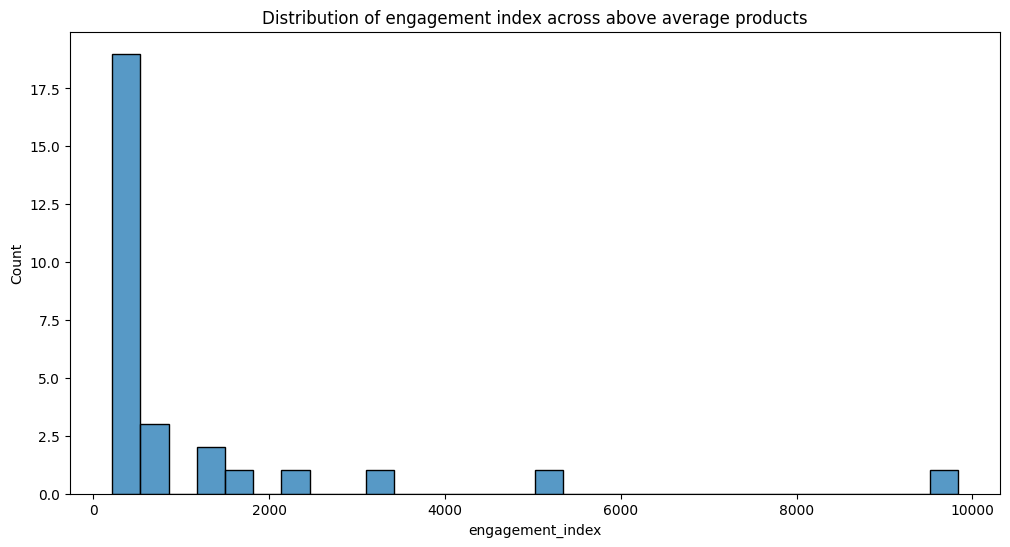

In [10]:
# Plotting the distribution of engagement index across above average products
plt.figure(figsize=(12,6))
sns.histplot(engagement_idx_by_product[engagement_idx_by_product['status'] == 'Above Average']['engagement_index'], bins=30)
plt.title('Distribution of engagement index across above average products')
plt.show()

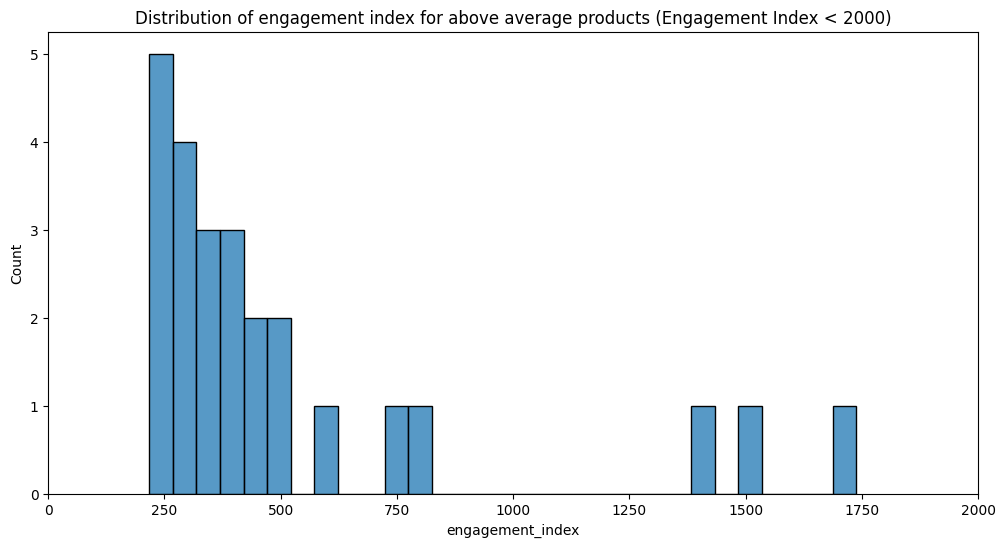

In [11]:
# Filter the DataFrame for products with engagement_index < 2000 and status 'Above Average'
filtered_data = engagement_idx_by_product[(engagement_idx_by_product['status'] == 'Above Average') & 
                                          (engagement_idx_by_product['engagement_index'] < 2000)]

# Plot the histogram
plt.figure(figsize=(12,6))
sns.histplot(filtered_data['engagement_index'], bins=30)

# Set the x-axis limits (optional, just to ensure you focus on the range)
plt.xlim(0, 2000)

# Add title and show the plot
plt.title('Distribution of engagement index for above average products (Engagement Index < 2000)')
plt.show()

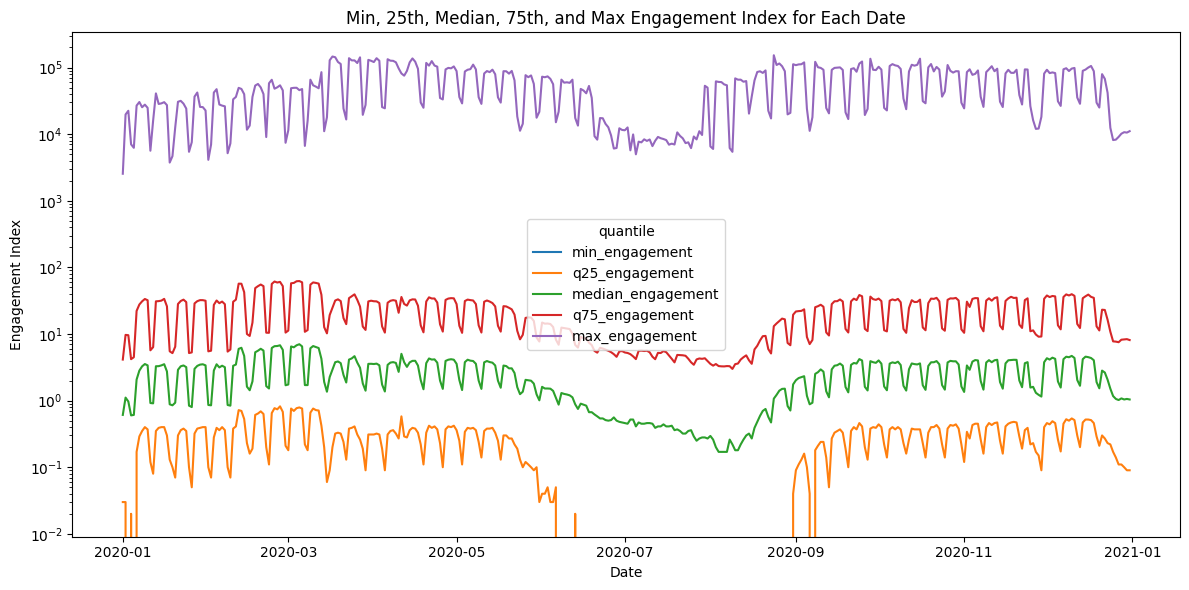

In [12]:
# Calculate the min, 25th percentile, median, 75th percentile, and max for each date
quantiles_by_date = engagement_data_filtered.groupby('time').agg(
    min_engagement=('engagement_index', 'min'),
    q25_engagement=('engagement_index', lambda x: x.quantile(0.25)),
    median_engagement=('engagement_index', 'median'),
    q75_engagement=('engagement_index', lambda x: x.quantile(0.75)),
    max_engagement=('engagement_index', 'max')
).reset_index()

# Melt the DataFrame to long format for easier plotting with seaborn
quantiles_long = quantiles_by_date.melt(id_vars='time', 
                                        value_vars=['min_engagement', 'q25_engagement', 'median_engagement', 'q75_engagement', 'max_engagement'],
                                        var_name='quantile', 
                                        value_name='engagement_index')

# Plotting the quantiles
plt.figure(figsize=(12,6))
sns.lineplot(data=quantiles_long, x='time', y='engagement_index', hue='quantile')

# Add title and labels
plt.title('Min, 25th, Median, 75th, and Max Engagement Index for Each Date')
plt.xlabel('Date')
plt.ylabel('Engagement Index')

# y-axis in log scale
plt.yscale('log')

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
# Checking number of observations that have engagement index below a certain threshold
threshold = 10
low_engagement = engagement_data_filtered[engagement_data_filtered['engagement_index'] <= threshold]
print(f'Number of observations with engagement index below {threshold}: {len(low_engagement)}')

Number of observations with engagement index below 10: 7902606


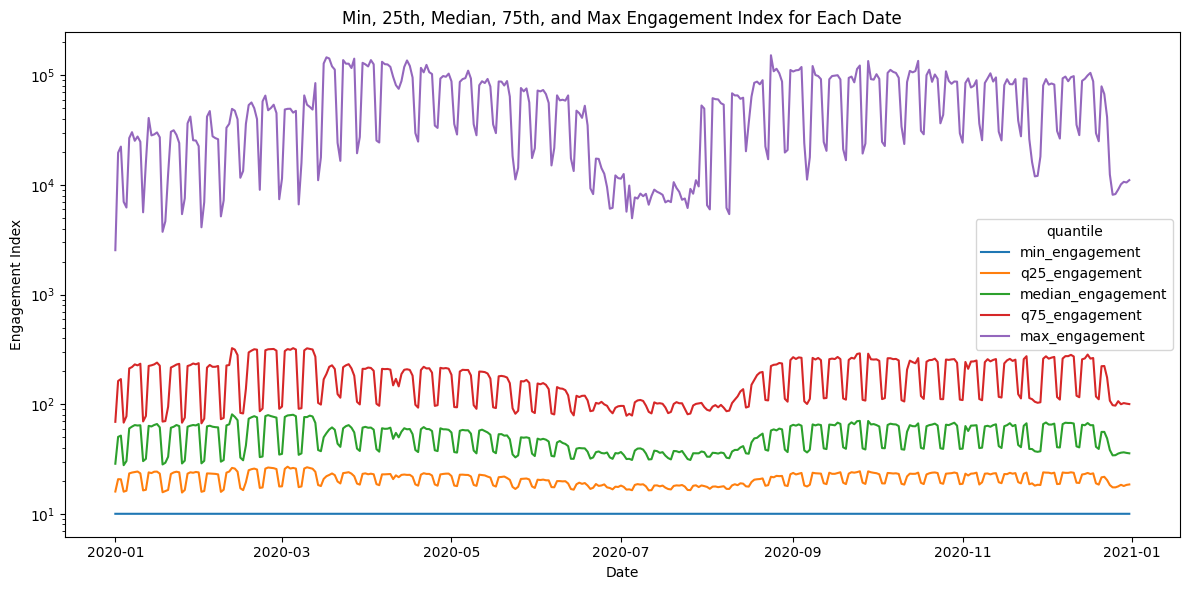

In [14]:
# Let's plot the min, quartiles, median, and max engagement index after taking out the low_engagement data
quantiles_by_date_filtered = engagement_data_filtered[~engagement_data_filtered.index.isin(low_engagement.index)].groupby('time').agg(
    min_engagement=('engagement_index', 'min'),
    q25_engagement=('engagement_index', lambda x: x.quantile(0.25)),
    median_engagement=('engagement_index', 'median'),
    q75_engagement=('engagement_index', lambda x: x.quantile(0.75)),
    max_engagement=('engagement_index', 'max')
).reset_index()

# Melt the DataFrame to long format for easier plotting with seaborn
quantiles_long_filtered = quantiles_by_date_filtered.melt(id_vars='time', 
                                        value_vars=['min_engagement', 'q25_engagement', 'median_engagement', 'q75_engagement', 'max_engagement'],
                                        var_name='quantile', 
                                        value_name='engagement_index')

# Plotting the quantiles
plt.figure(figsize=(12,6))
sns.lineplot(data=quantiles_long_filtered, x='time', y='engagement_index', hue='quantile')

# Add title and labels
plt.title('Min, 25th, Median, 75th, and Max Engagement Index for Each Date')
plt.xlabel('Date')
plt.ylabel('Engagement Index')

# y-axis in log scale
plt.yscale('log')

# Show the plot
plt.tight_layout()
plt.show()


In [15]:
# Filter out the low engagement data from the engagement_data_filtered DataFrame
# Here the threshold for low engagement is set to 10
engagement_data_filtered = engagement_data_filtered[~engagement_data_filtered.index.isin(low_engagement.index)]

# Save the filtered engagement data to a parquet file
engagement_data_filtered.to_parquet(os.path.join(data_dir, 'engagement_data_filtered_above_ten.parquet'))

In [16]:
# Read in the engagement_filtered parquet file
engagement_data_filtered_above_ten = pd.read_parquet(os.path.join(data_dir, 'engagement_data_filtered_above_ten.parquet'))
engagement_data_filtered_above_ten.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3788981 entries, 16 to 22324185
Data columns (total 11 columns):
 #   Column            Dtype         
---  ------            -----         
 0   time              datetime64[ns]
 1   lp_id             int64         
 2   pct_access        float64       
 3   engagement_index  float64       
 4   district_id       int64         
 5   covid             int64         
 6   day_of_week       int32         
 7   weekday           int64         
 8   month             int32         
 9   day               int32         
 10  week              UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(2), int32(3), int64(4)
memory usage: 292.7 MB


### <ins>EDA Questions</ins>:
Our analysis that led to this filtering process highlighted that adoption across products and time is highly skewed. Few products seem to have super high engagement indices but we are not sure during what time of the year that happens

1. How many products are represented in the data now?
2. Which products have the highest average engagement index? What is the nature of these products?
3. For these highest engagement products, what does engagement look like over time?

**Examining district data:**
1. How does the engagement change across districts over time?
2. How do districts differ if the usage changes? Does the engagement depend on expenditure or % of minority community children?

In [17]:
# Checking average and median engagement index across all products
print(f"Mean engagement index across all products is {round(engagement_data_filtered_above_ten['engagement_index'].mean(),2)}")
print(f"Median engagement index across all products is {round(engagement_data_filtered_above_ten['engagement_index'].median(),2)}")

Mean engagement index across all products is 635.99
Median engagement index across all products is 54.34


In [18]:
# Checking the engagement index across products
engagement_idx_by_product = engagement_data_filtered_above_ten.groupby('lp_id')['engagement_index'].mean().reset_index()
engagement_idx_by_product = engagement_idx_by_product.sort_values(by='engagement_index', ascending=False)
print(f"Unique products in engagement data: {len(engagement_idx_by_product)}")
print(engagement_idx_by_product.head(150))

Unique products in engagement data: 369
     lp_id  engagement_index
349  95731      10589.833198
99   32213       5985.348764
43   20069       4464.194776
148  47364       4248.984657
211  61292       3418.318573
..     ...               ...
179  52448         79.846167
129  41424         79.010239
137  43491         78.711307
331  91873         77.519326
221  64124         76.815619

[150 rows x 2 columns]


In [19]:
# Add a label for engagement index - l1: between 10-100, l2: between 100-1000, l3: between: 1000-10000, l4: above 10000
engagement_idx_by_product['engagement_level'] = 'l1'
engagement_idx_by_product.loc[engagement_idx_by_product['engagement_index'] >= 100, 'engagement_level'] = 'l2'
engagement_idx_by_product.loc[engagement_idx_by_product['engagement_index'] >= 1000, 'engagement_level'] = 'l3'
engagement_idx_by_product.loc[engagement_idx_by_product['engagement_index'] >= 10000, 'engagement_level'] = 'l4'
engagement_idx_by_product.head(20)

,lp_id,engagement_index,engagement_level
349,95731,10589.833198,l4
99,32213,5985.348764,l3
43,20069,4464.194776,l3
148,47364,4248.984657,l3
211,61292,3418.318573,l3
365,98845,2590.360867,l3
60,24711,1811.512078,l3
279,78063,1342.145011,l3
102,33185,1058.114081,l3
208,59434,979.484590,l2


In [20]:
# Now let's merge this product information to check which products lie in l1, l2, l3, and l4

# Reading product data
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'data')
file_name = 'products_info_modified.csv'
file_path = os.path.join(data_dir, file_name)

# Read products csv file
df_products = pd.read_csv(file_path)

# Examine the data
print(f"Product data has {df_products.shape[0]} rows and {df_products.shape[1]} columns. Top 10 rows are:")
df_products.head(10)

Product data has 372 rows and 8 columns. Top 10 rows are:


,lp_id,url,product_name,company_name,sector,primary_function,secondary_function,tertiary_function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC,Digital Learning Platforms,Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC,Digital Learning Platforms,Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,LC,"Sites, Resources & Reference",Games & Simulations
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC,Digital Learning Platforms,Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC,Digital Learning Platforms,Digital Learning Platforms
5,37600,http://www.activelylearn.com/,Actively Learn,Actively Learn,PreK-12,LC,Digital Learning Platforms,Digital Learning Platforms
6,18663,http://www.adaptedmind.com,AdaptedMind,GloWorld,PreK-12,LC,Digital Learning Platforms,Digital Learning Platforms
7,65131,http://www.amplify.com/,Amplify,"Amplify Education, Inc.",PreK-12,LC,Courseware & Textbooks,Courseware & Textbooks
8,26491,http://www.answers.com/,Answers,Answers,PreK-12; Higher Ed,LC,Study Tools,Q&A
9,56441,http://www.audible.com,Audible,"Amazon.com, Inc.",PreK-12; Higher Ed; Corporate,LC,"Sites, Resources & Reference",Streaming Services


In [21]:
# Now let's merge the engagement data with the product data to examine nature of l1, l2, l3, and l4 products
engagement_idx_by_product_info = engagement_idx_by_product.merge(df_products, left_on='lp_id', right_on='lp_id', how='left')
drop_columns = ['url','company_name','sector']
engagement_idx_by_product_info.drop(drop_columns, axis=1, inplace=True)
engagement_idx_by_product_info.head(50)

,lp_id,engagement_index,engagement_level,product_name,primary_function,secondary_function,tertiary_function
0,95731,10589.833198,l4,Google Docs,LC,Content Creation & Curation,Content Creation & Curation
1,32213,5985.348764,l3,Google Classroom,SDO,Learning Management Systems (LMS),Learning Management Systems (LMS)
2,20069,4464.194776,l3,Schoology,SDO,Learning Management Systems (LMS),Learning Management Systems (LMS)
3,47364,4248.984657,l3,Canvas,LC,Online Course Providers & Technical Skills Dev...,Online Course Providers & Technical Skills Dev...
4,61292,3418.318573,l3,YouTube,LC,"Sites, Resources & Reference",Streaming Services
5,98845,2590.360867,l3,Meet,CM,Virtual Classroom,Video Conferencing & Screen Sharing
6,24711,1811.512078,l3,Kahoot!,LC,Study Tools,Study Tools
7,78063,1342.145011,l3,ClassLink,SDO,School Management Software,SSO
8,33185,1058.114081,l3,Google Forms,CM,Classroom Engagement & Instruction,Assessment & Classroom Response
9,59434,979.484590,l2,Seesaw : The Learning Journal,LC,Content Creation & Curation,Content Creation & Curation


In [50]:
# Save this dataframe to a parquet file for future analysis with districts
engagement_idx_by_product_info.to_parquet(os.path.join(data_dir, 'engagement_idx_by_product_info.parquet'))

In [22]:
# Check the counts of products in each engagement level
engagement_idx_by_product_info['engagement_level'].value_counts()

engagement_level
l1    245
l2    115
l3      8
l4      1
Name: count, dtype: int64

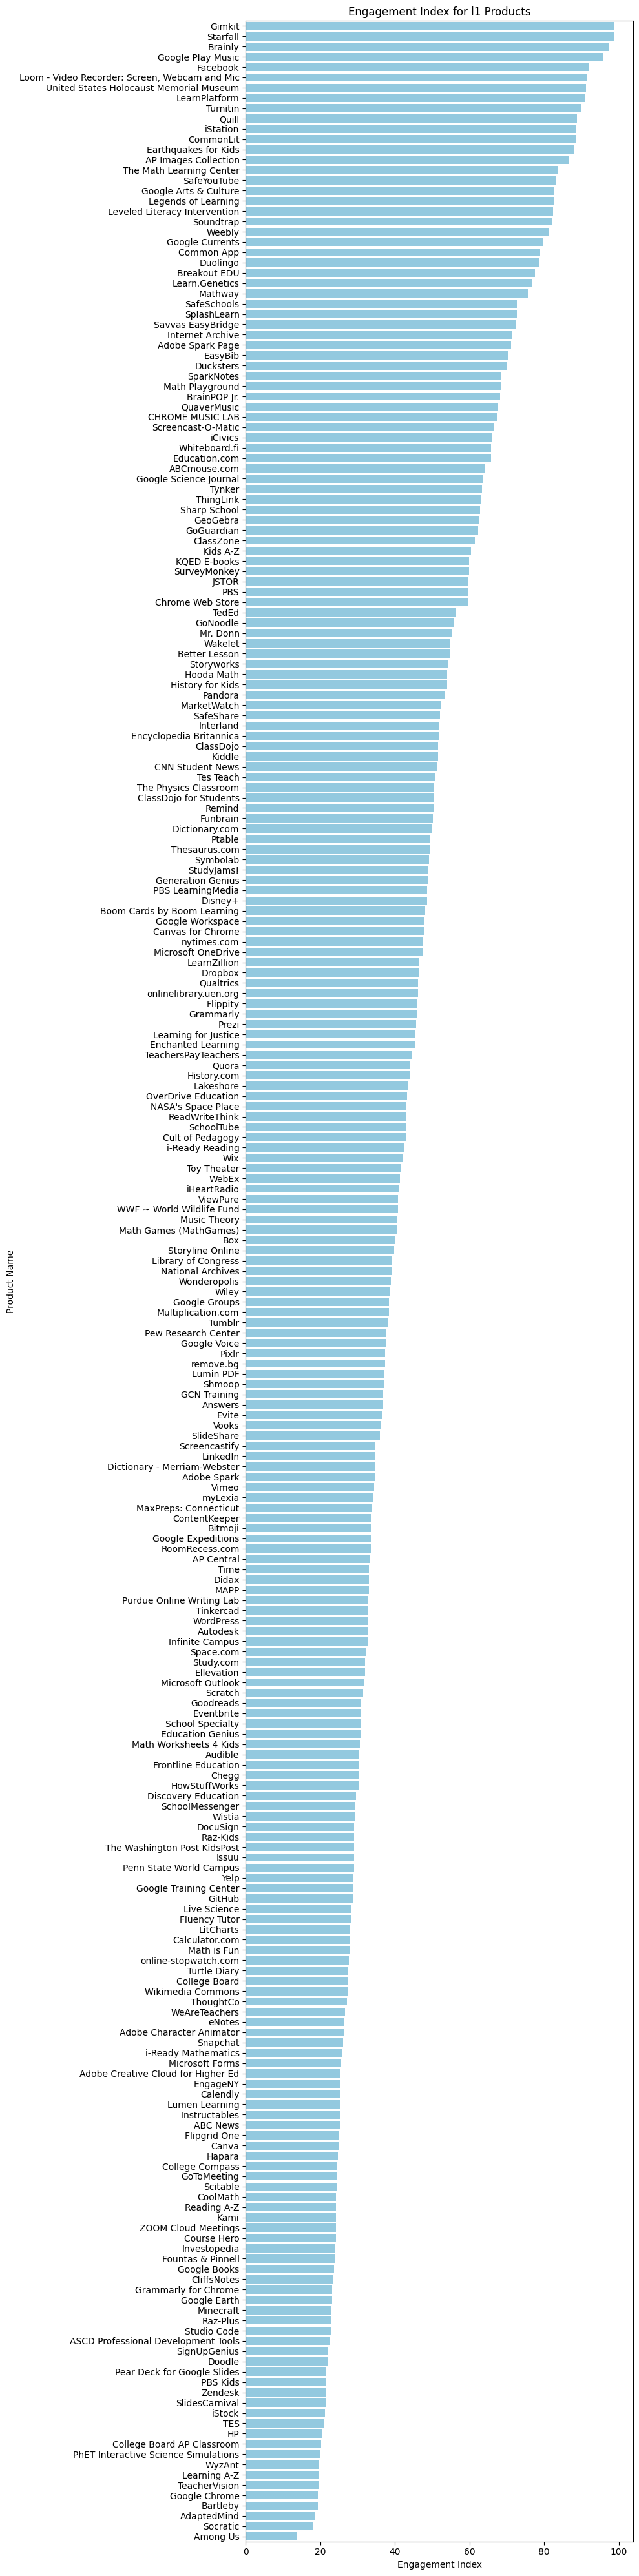

In [23]:
# Histogram of engagement index for l1, l2 products only (represented by hue)
# Filter the data for l1 and l2 products
l1_data = engagement_idx_by_product_info[engagement_idx_by_product_info['engagement_level'].isin(['l1'])]
l2_data = engagement_idx_by_product_info[engagement_idx_by_product_info['engagement_level'].isin(['l2'])]

# Filter the data for l3 and l4 products
l3_l4_data = engagement_idx_by_product_info[engagement_idx_by_product_info['engagement_level'].isin(['l3', 'l4'])]

# Plot the histogram for l1 products
plt.figure(figsize=(10,40))  # Increased figure size for better readability
sns.barplot(x='engagement_index', y='product_name', data=l1_data, color="skyblue")
plt.title('Engagement Index for l1 Products')
plt.xlabel('Engagement Index')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

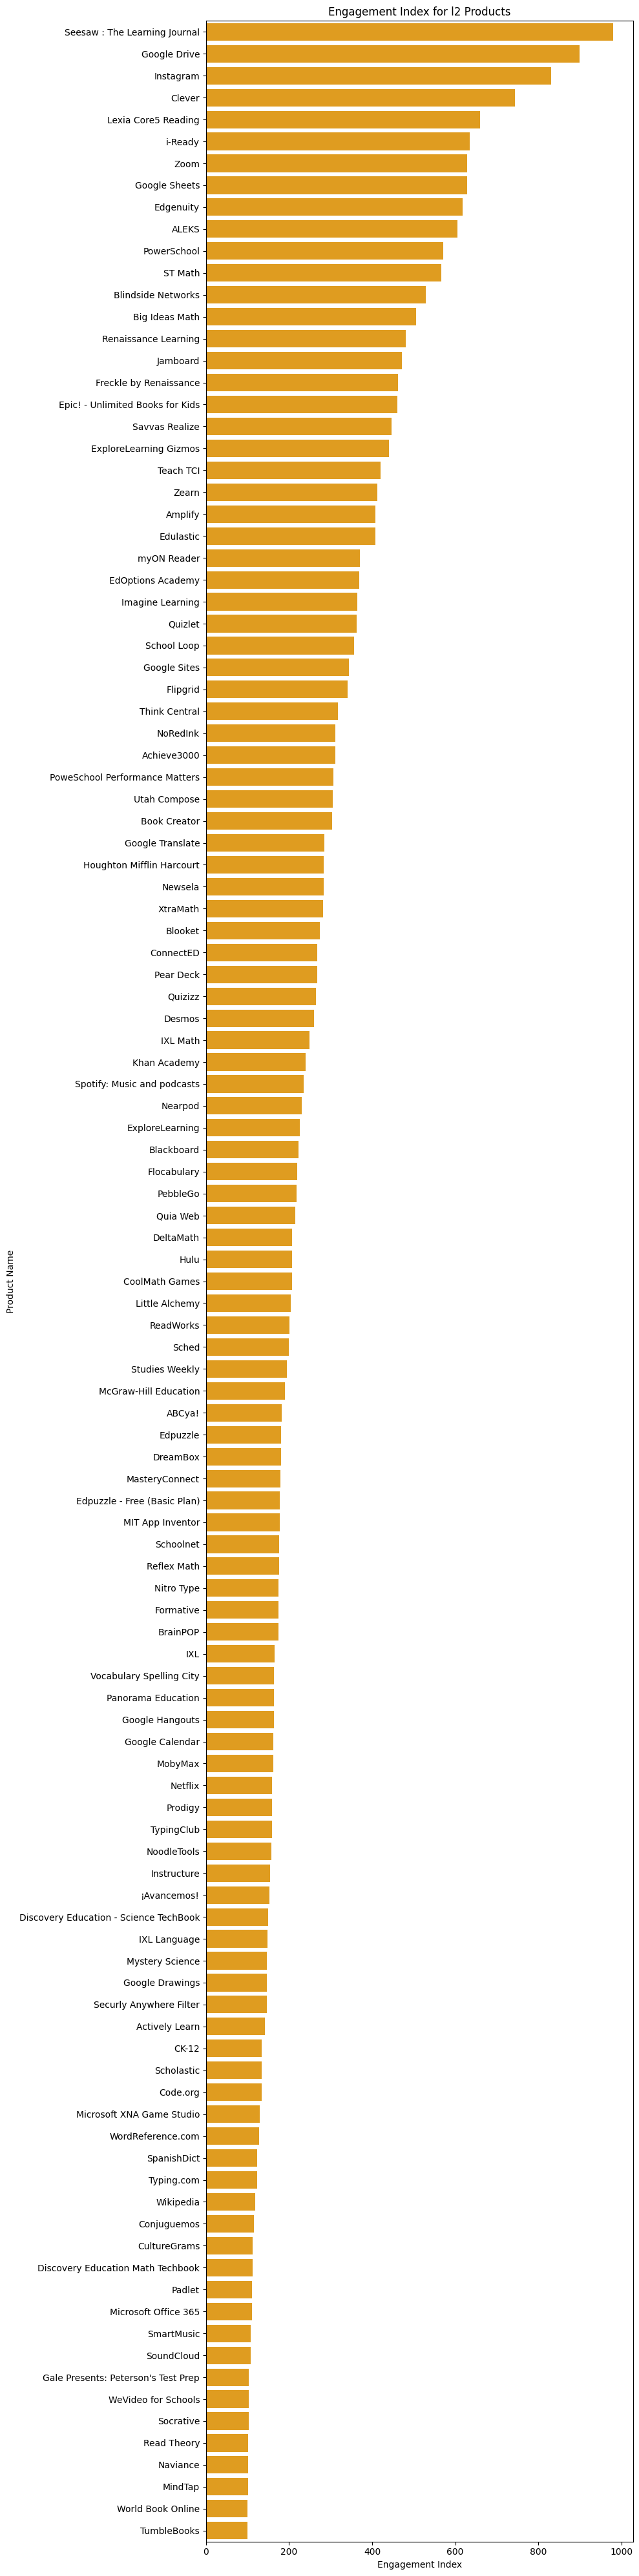

In [24]:
# Plot the histogram for l2 products
plt.figure(figsize=(10,40))  # Increased figure size for better readability
sns.barplot(x='engagement_index', y='product_name', data=l2_data, color="orange")
plt.title('Engagement Index for l2 Products')
plt.xlabel('Engagement Index')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

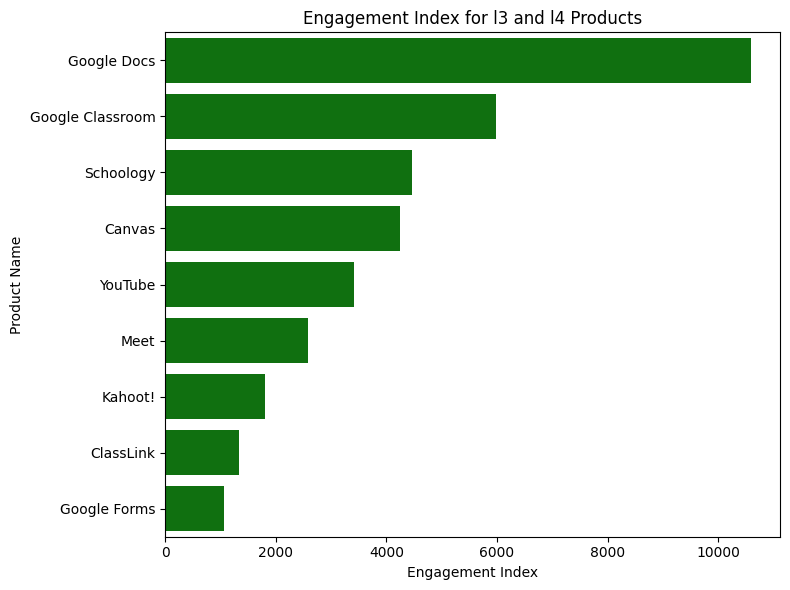

In [25]:
# Plot the histogram for l3 and l4 products
plt.figure(figsize=(8,6))  # Increased figure size for better readability
sns.barplot(x='engagement_index', y='product_name', data=l3_l4_data, color="green")
plt.title('Engagement Index for l3 and l4 Products')
plt.xlabel('Engagement Index')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

In [26]:
# Now let's merge engagement_idx_by_product_info with engagement_data_filtered_above_ten to assess trends over time
engagement_data_filtered_merged = engagement_data_filtered_above_ten.merge(engagement_idx_by_product_info, left_on='lp_id', right_on='lp_id', how='left')

# Drop column 'engagement_index_y' and rename 'engagement_index_x' to 'engagement_index'
engagement_data_filtered_merged.drop('engagement_index_y', axis=1, inplace=True)
engagement_data_filtered_merged.rename(columns={'engagement_index_x':'engagement_index'}, inplace=True)
engagement_data_filtered_merged.head()

,time,lp_id,pct_access,engagement_index,district_id,covid,day_of_week,weekday,month,day,week,engagement_level,product_name,primary_function,secondary_function,tertiary_function
0,2020-01-01,32213,0.22,31.66,3188,0,2,1,1,1,1,l3,Google Classroom,SDO,Learning Management Systems (LMS),Learning Management Systems (LMS)
1,2020-01-01,95731,0.30,45.97,3188,0,2,1,1,1,1,l4,Google Docs,LC,Content Creation & Curation,Content Creation & Curation
2,2020-01-02,28525,6.16,108.41,3188,0,3,1,1,2,1,l2,Renaissance Learning,LC,Digital Learning Platforms,Digital Learning Platforms
3,2020-01-02,98402,6.29,449.70,3188,0,3,1,1,2,1,l2,Reflex Math,LC,Digital Learning Platforms,Digital Learning Platforms
4,2020-01-02,98265,0.87,56.81,3188,0,3,1,1,2,1,l2,Quizlet,LC,Study Tools,Study Tools


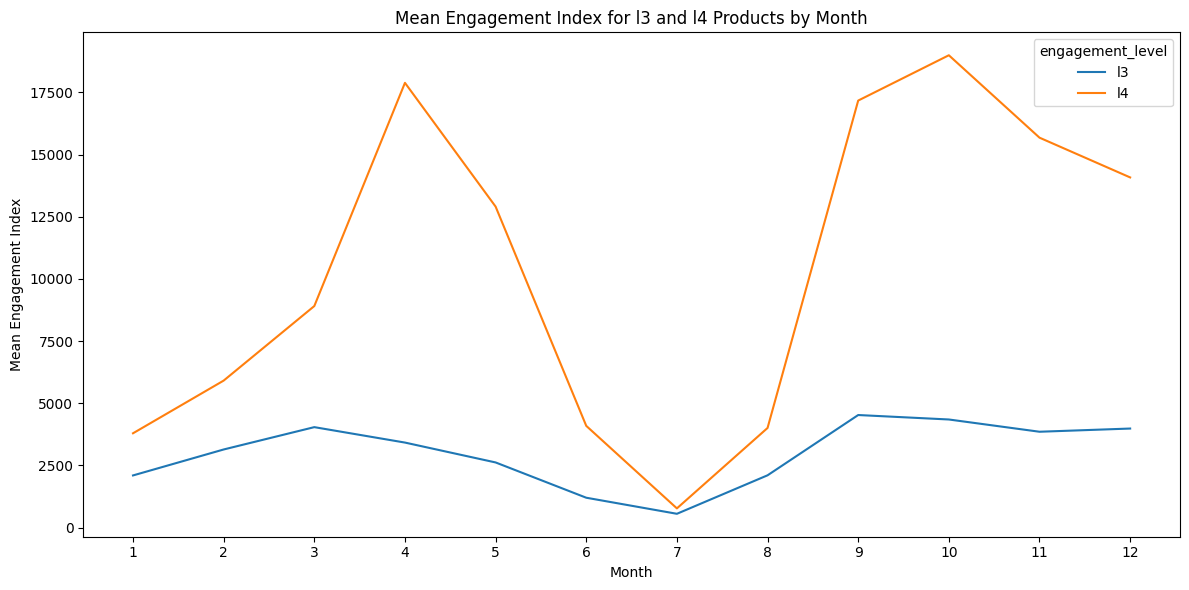

In [27]:
# Analysis of l3 and l4 products over months and dates
# Filter the data for l3 and l4 products
l3_l4_merged_data = engagement_data_filtered_merged[engagement_data_filtered_merged['engagement_level'].isin(['l3', 'l4'])]

# Calculate the mean engagement index for each month
l3_l4_monthly = l3_l4_merged_data.groupby(['month', 'engagement_level'])['engagement_index'].mean().reset_index()

# Plot the lineplot
plt.figure(figsize=(12,6))
sns.lineplot(data=l3_l4_monthly, x='month', y='engagement_index', hue='engagement_level')
plt.title('Mean Engagement Index for l3 and l4 Products by Month')

#Plot all values from 1-12 on the x-axis
plt.xticks(range(1, 13)) 
plt.xlabel('Month')
plt.ylabel('Mean Engagement Index')
plt.tight_layout()
plt.show()

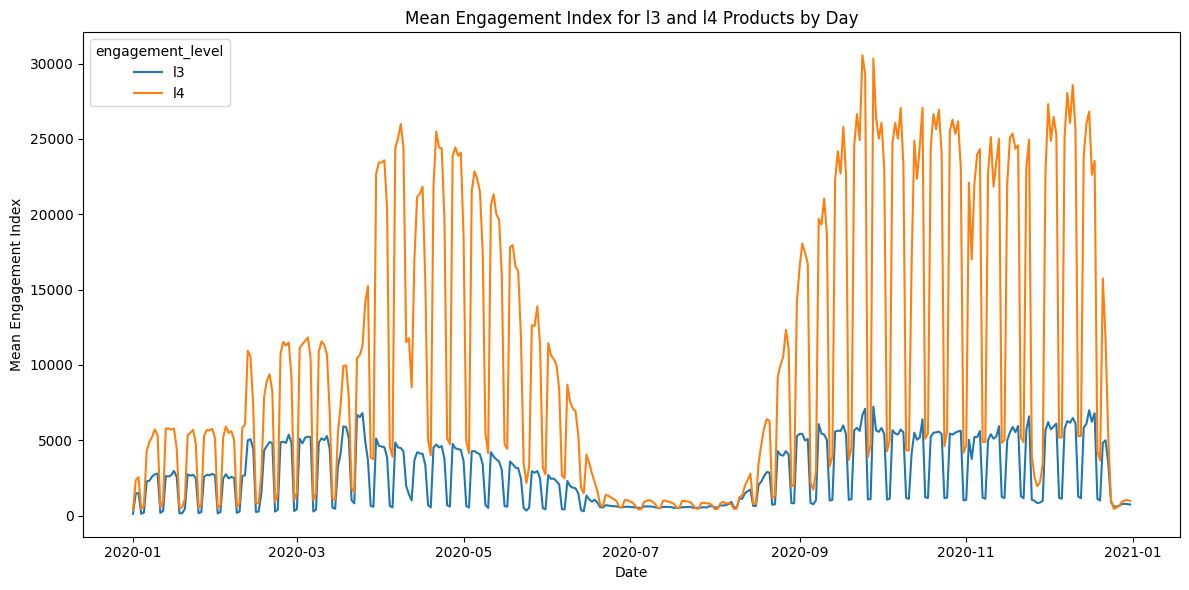

In [28]:
# Daily engagement index for l3 and l4 products
# Calculate the mean engagement index for each date
l3_l4_daily = l3_l4_merged_data.groupby(['time', 'engagement_level'])['engagement_index'].mean().reset_index()

# Plot the lineplot 
plt.figure(figsize=(12,6))
sns.lineplot(data=l3_l4_daily, x='time', y='engagement_index', hue='engagement_level')
plt.title('Mean Engagement Index for l3 and l4 Products by Day')
plt.xlabel('Date')
plt.ylabel('Mean Engagement Index')
plt.tight_layout()
plt.show()

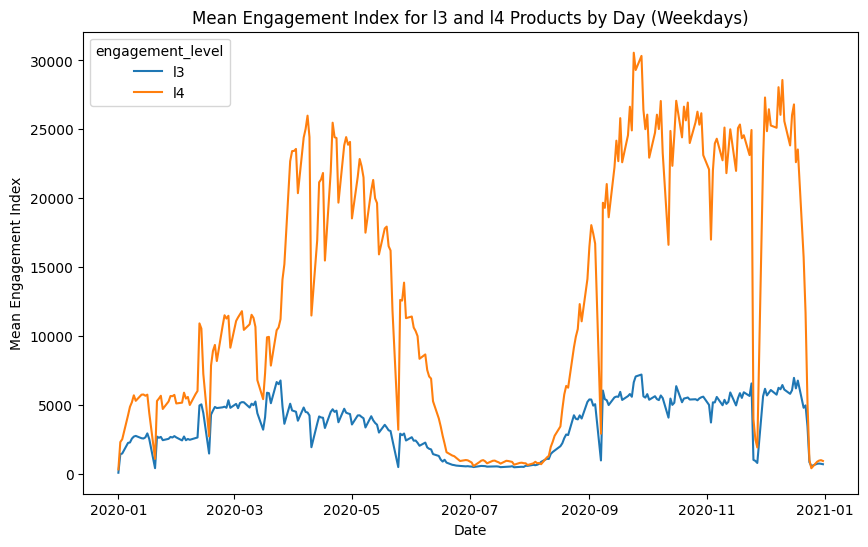

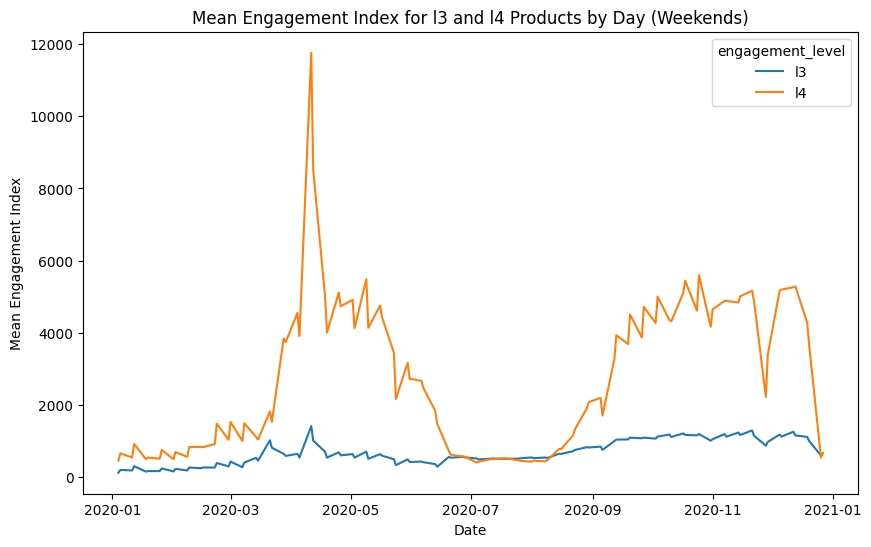

In [29]:
# Split the daily engagement index by day of the week (weekday and weekend)
# Calculate the mean engagement index for each date and day of the week

# Create new dataframes for weekday and weekend data
l3_l4_weekday_data = l3_l4_merged_data[l3_l4_merged_data['weekday'] == 1]
l3_l4_weekend_data = l3_l4_merged_data[l3_l4_merged_data['weekday'] == 0]

# Calculate the mean engagement index for each date and day of the week
l3_l4_weekday_mean = l3_l4_weekday_data.groupby(['time', 'engagement_level'])['engagement_index'].mean().reset_index()
l3_l4_weekend_mean = l3_l4_weekend_data.groupby(['time', 'engagement_level'])['engagement_index'].mean().reset_index()

# Plotting weekday engagement index
plt.figure(figsize=(10, 6))
sns.lineplot(data=l3_l4_weekday_mean, x='time', y='engagement_index', hue='engagement_level')
plt.title('Mean Engagement Index for l3 and l4 Products by Day (Weekdays)')
plt.xlabel('Date')
plt.ylabel('Mean Engagement Index')
plt.show()

# Plotting weekend engagement index
plt.figure(figsize=(10, 6))
sns.lineplot(data=l3_l4_weekend_mean, x='time', y='engagement_index', hue='engagement_level')
plt.title('Mean Engagement Index for l3 and l4 Products by Day (Weekends)')
plt.xlabel('Date')
plt.ylabel('Mean Engagement Index')
plt.show()

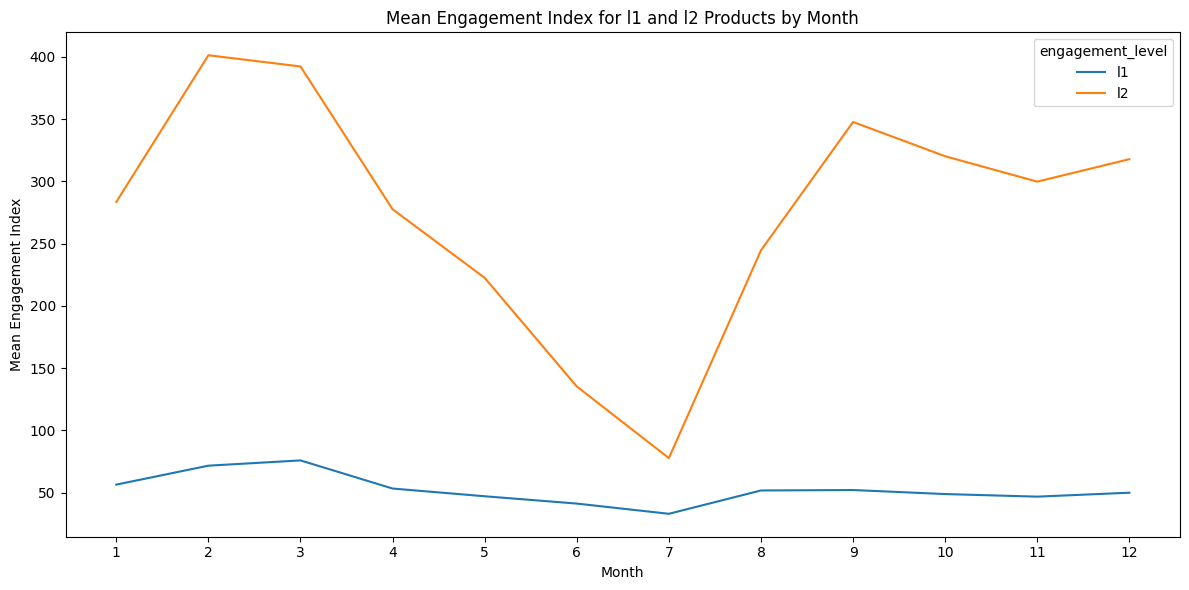

In [30]:
# Analysis of l1 and l2 products over months and dates
# Filter the data for l1 and l2 products
l1_l2_merged_data = engagement_data_filtered_merged[engagement_data_filtered_merged['engagement_level'].isin(['l1', 'l2'])]

# Calculate the mean engagement index for each month
l1_l2_monthly = l1_l2_merged_data.groupby(['month', 'engagement_level'])['engagement_index'].mean().reset_index()

# Plot the lineplot
plt.figure(figsize=(12,6))
sns.lineplot(data=l1_l2_monthly, x='month', y='engagement_index', hue='engagement_level')
plt.title('Mean Engagement Index for l1 and l2 Products by Month')

#Plot all values from 1-12 on the x-axis
plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('Mean Engagement Index')
plt.tight_layout()
plt.show()

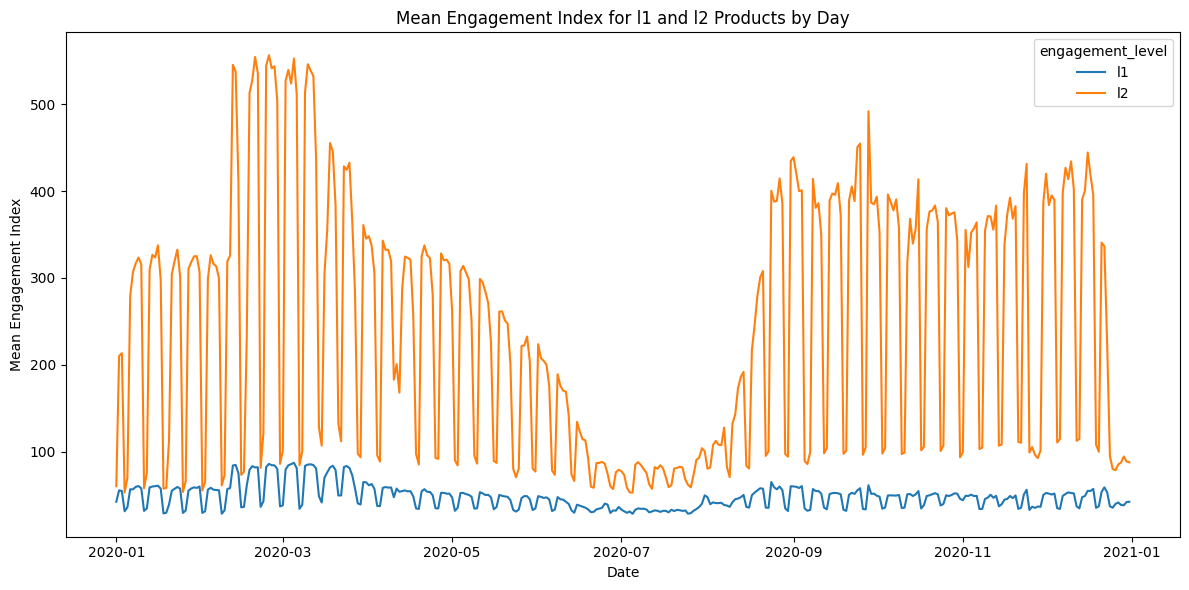

In [31]:
# Daily engagement index for l1 and l2 products
# Calculate the mean engagement index for each date
l1_l2_daily = l1_l2_merged_data.groupby(['time', 'engagement_level'])['engagement_index'].mean().reset_index()

# Plot the lineplot
plt.figure(figsize=(12,6))
sns.lineplot(data=l1_l2_daily, x='time', y='engagement_index', hue='engagement_level')
plt.title('Mean Engagement Index for l1 and l2 Products by Day')
plt.xlabel('Date')
plt.ylabel('Mean Engagement Index')
plt.tight_layout()
plt.show()

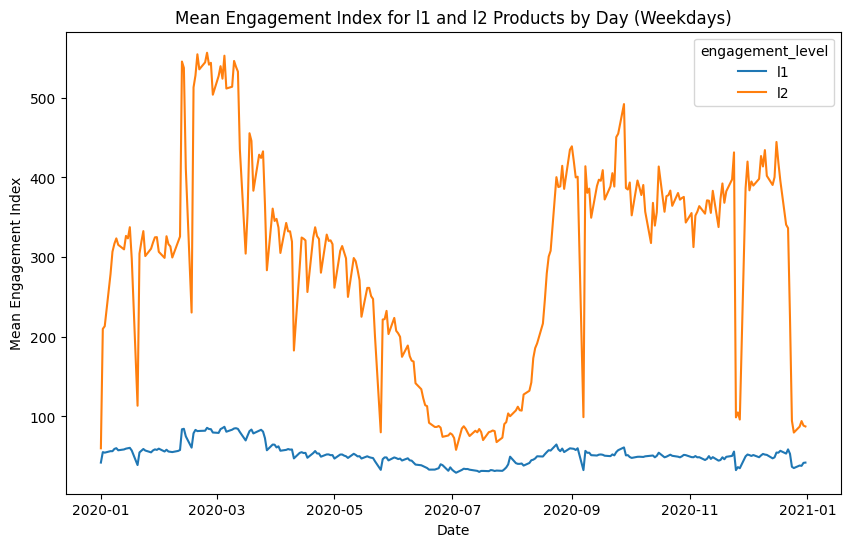

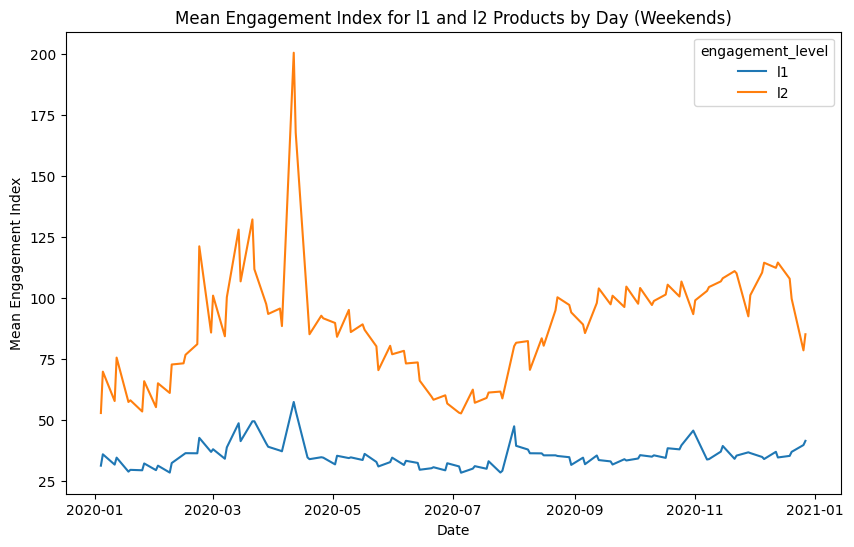

In [32]:
# Split the daily engagement index by day of the week (weekday and weekend)
# Calculate the mean engagement index for each date and day of the week

# Create new dataframes for weekday and weekend data
l1_l2_weekday_data = l1_l2_merged_data[l1_l2_merged_data['weekday'] == 1]
l1_l2_weekend_data = l1_l2_merged_data[l1_l2_merged_data['weekday'] == 0]

# Calculate the mean engagement index for each date and day of the week
l1_l2_weekday_mean = l1_l2_weekday_data.groupby(['time', 'engagement_level'])['engagement_index'].mean().reset_index()
l1_l2_weekend_mean = l1_l2_weekend_data.groupby(['time', 'engagement_level'])['engagement_index'].mean().reset_index()

# Plotting weekday engagement index
plt.figure(figsize=(10, 6))
sns.lineplot(data=l1_l2_weekday_mean, x='time', y='engagement_index', hue='engagement_level')
plt.title('Mean Engagement Index for l1 and l2 Products by Day (Weekdays)')
plt.xlabel('Date')
plt.ylabel('Mean Engagement Index')
plt.show()

# Plotting weekend engagement index
plt.figure(figsize=(10, 6))
sns.lineplot(data=l1_l2_weekend_mean, x='time', y='engagement_index', hue='engagement_level')
plt.title('Mean Engagement Index for l1 and l2 Products by Day (Weekends)')
plt.xlabel('Date')
plt.ylabel('Mean Engagement Index')
plt.show()

In [45]:
# Let's check the count of l1, l2, l3, and l4 products by primary function
# We will also examine their mean engagement index

engagement_level_by_function = engagement_idx_by_product_info.groupby(['primary_function', 'engagement_level'])['lp_id'].count().reset_index()
engagement_level_by_function = engagement_level_by_function.pivot(index='primary_function', columns='engagement_level', values='lp_id').reset_index()
engagement_level_by_function.fillna(0, inplace=True)

# Adding a column called Total that sums l1,l2,l3 and l4 columns
engagement_level_by_function['Total'] = engagement_level_by_function['l1'] + engagement_level_by_function['l2'] + engagement_level_by_function['l3'] + engagement_level_by_function['l4']

# Adding a row called Total that sums l1,l2,l3 and l4 rows
engagement_level_by_function.loc['Total'] = engagement_level_by_function.sum()

engagement_level_by_function

engagement_level,primary_function,l1,l2,l3,l4,Total
0,CM,28.0,4.0,2.0,0.0,34.0
1,LC,173.0,94.0,3.0,1.0,271.0
2,LC/CM/SDO,12.0,4.0,0.0,0.0,16.0
3,SDO,16.0,10.0,3.0,0.0,29.0
Total,CMLCLC/CM/SDOSDO,229.0,112.0,8.0,1.0,350.0


### Engagement index patterns seem to be similar - this means the products, when available, "are used" the same way by students. Does higher or lower engagement then depend on access?

In [49]:
# Check correlation between engagement index and pct_access in engagement_data_filtered_merged
correlation = engagement_data_filtered_merged[['engagement_index', 'pct_access']].corr()
print(f"Correlation between engagement index and pct_access: {round(correlation.loc['engagement_index', 'pct_access'],2)}")

# We can also check correlation separately for l1, l2 and l3, l4 products
# We have l3_l4_merged_data and l1_l2_merged_data

# Check correlation between engagement index and pct_access for l1 and l2 products
correlation_l1_l2 = l1_l2_merged_data[['engagement_index', 'pct_access']].corr()
print(f"Correlation between engagement index and pct_access for l1 and l2 products: {round(correlation_l1_l2.loc['engagement_index', 'pct_access'],2)}")

# Check correlation between engagement index and pct_access for l3 and l4 products
correlation_l3_l4 = l3_l4_merged_data[['engagement_index', 'pct_access']].corr()
print(f"Correlation between engagement index and pct_access for l3 and l4 products: {round(correlation_l3_l4.loc['engagement_index', 'pct_access'],2)}")

# Check correlation between engagement index and pct_access for only l1 products
l1_data = engagement_data_filtered_merged[engagement_data_filtered_merged['engagement_level'] == 'l1']
correlation_l1 = l1_data[['engagement_index', 'pct_access']].corr()
print(f"Correlation between engagement index and pct_access for l1 products: {round(correlation_l1.loc['engagement_index', 'pct_access'],2)}")

# Check correlation between engagement index and pct_access for only l1 products
l2_data = engagement_data_filtered_merged[engagement_data_filtered_merged['engagement_level'] == 'l2']
correlation_l2 = l2_data[['engagement_index', 'pct_access']].corr()
print(f"Correlation between engagement index and pct_access for l2 products: {round(correlation_l2.loc['engagement_index', 'pct_access'],2)}")

Correlation between engagement index and pct_access: 0.73
Correlation between engagement index and pct_access for l1 and l2 products: 0.73
Correlation between engagement index and pct_access for l3 and l4 products: 0.76
Correlation between engagement index and pct_access for l1 products: 0.56
Correlation between engagement index and pct_access for l2 products: 0.73
